# Gesture Recognition Case Study

### Team Members:
### Aman Shah
### Saravanan S E

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# Import required libraries
import numpy as np
import os
import cv2
import datetime
import os
from PIL import Image
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.applications import MobileNet, MobileNetV2
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.recurrent import GRU

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
import keras
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('../input/project1/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../input/project1/Project_data/val.csv').readlines())

In [5]:
# Defining the parameters
img_height = 120
img_width = 120
batch_size = 50
num_epochs = 20
channel = 3
img_select = 2
lr = 0.001
lr_reduce_factor = 0.5

# Generator 1
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
# The image is cropped and then resize in this generator
def generator_crop_resize(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [X for X in range(0,30,img_select)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[0] != image.shape[1]:
                      image = image[0:120,20:140]
                    image_size_change = cv2.resize(image,(img_width,img_height),interpolation=cv2.INTER_AREA)
        
                    batch_data[folder,idx,:,:,0] = (image_size_change[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_size_change[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_size_change[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
 
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
          batch_size = len(folder_list) - (batch_size*num_batches)
          batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
          for folder in range(batch_size): # iterate over the batch_size
              imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                  #crop the images and resize them. Note that the images are of 2 different shape 
                  #and the conv3D will throw error if the inputs in a batch have different shapes
                  if image.shape[0] != image.shape[1]:
                    image = image[0:120,20:140]
                  image_size_change = cv2.resize(image,(img_width,img_height),interpolation=cv2.INTER_AREA)

                  batch_data[folder,idx,:,:,0] = (image_size_change[:,:,0])/255
                  batch_data[folder,idx,:,:,1] = (image_size_change[:,:,1])/255
                  batch_data[folder,idx,:,:,2] = (image_size_change[:,:,2])/255
                    
              batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


# Generator 2

In [7]:
# Image is only resize in this generator
def generator_resize(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [X for X in range(0,30,img_select)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #resize images. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_size_change = cv2.resize(image,(img_width,img_height),interpolation=cv2.INTER_AREA)
        
                    batch_data[folder,idx,:,:,0] = (image_size_change[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_size_change[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_size_change[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
 
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
          batch_size = len(folder_list) - (batch_size*num_batches)
          batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
          for folder in range(batch_size): # iterate over the batch_size
              imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #resize images. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                  image_size_change = cv2.resize(image,(img_width,img_height),interpolation=cv2.INTER_AREA)

                  batch_data[folder,idx,:,:,0] = (image_size_change[:,:,0])/255
                  batch_data[folder,idx,:,:,1] = (image_size_change[:,:,1])/255
                  batch_data[folder,idx,:,:,2] = (image_size_change[:,:,2])/255
                    
              batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '../input/project1/Project_data/train'
val_path = '../input/project1/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=lr_reduce_factor, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Model 1 - Convolutional Neural Nework
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
# Define the model
model_1 = Sequential()
model_1.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(30//img_select,img_width,img_height,channel),padding='same'))
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_1.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_1.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_1.add(Dropout(0.25))
model_1.add(Flatten())
model_1.add(Dense(128,activation='relu'))
model_1.add(Dense(5,activation='softmax')) 

## Experiment 1
#### Model = model_1
#### Type = Convolutional Neural Network
#### Optimizer = Adam
#### num_epochs = 20
#### batch_size = 50
#### Generator = generator_crop_resize

In [12]:
train_generator = generator_crop_resize(train_path, train_doc, batch_size)
val_generator = generator_crop_resize(val_path, val_doc, batch_size)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
# Model compile
opt = keras.optimizers.Adam(learning_rate=lr)
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
# Model fit
history = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project1/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - 102s 8s/step - loss: 1.7978 - categorical_accuracy: 0.2010 - val_loss: 1.5257 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-03-0722_23_02.408022/model-00001-1.69248-0.20060-1.52568-0.23000.h5
Epoch 2/20
14/14 [==============================] - 19s 1s/step - loss: 1.4860 - categorical_accuracy: 0.2529 - val_loss: 1.5871 - val_categorical_accuracy: 0.3400

Epoch 00002: saving model to model_init_2021-03-0722_23_02.408022/model-00002-1.51549-0.25275-1.58707-0.34000.h5
Epoch 3/20
14/14 [==============================] - 20s 2s/step - loss: 1.5617 - categorical_accuracy: 0.3024 - val_loss: 1.3901 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_2021-03-0722_23_02.408022/model-00003-1.54014-0.30769-1.39014-0.33000.h5
Epoch 4/20
14/14 [==============================] - 19s 1s/step - loss: 1.4998 - categorical_ac

In [15]:
# Model summary
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 30, 30, 64)     5

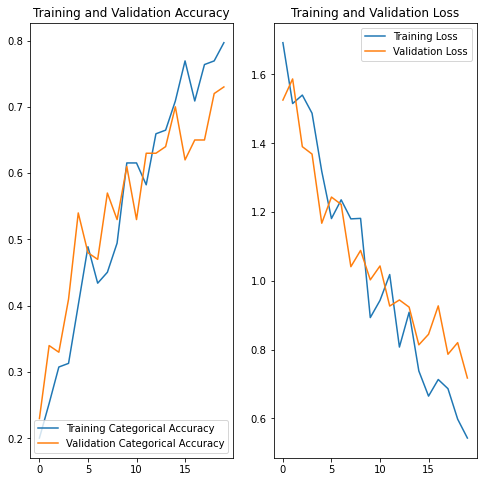

In [16]:
# Visualize the Model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 2
#### Model = model_1
#### Type = Convolutional Neural Network
#### Optimizer = Adam
#### num_epochs = 20
#### batch_size = 50
#### Generator = generator_resize

In [17]:
train_generator = generator_resize(train_path, train_doc, batch_size)
val_generator = generator_resize(val_path, val_doc, batch_size)

In [18]:
# Model compile
opt = keras.optimizers.Adam(learning_rate=lr)
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [19]:
# Model fit
history = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project1/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - 45s 3s/step - loss: 0.7264 - categorical_accuracy: 0.7295 - val_loss: 0.8784 - val_categorical_accuracy: 0.6600

Epoch 00001: saving model to model_init_2021-03-0722_23_02.408022/model-00001-0.71634-0.72097-0.87837-0.66000.h5
Epoch 2/20
14/14 [==============================] - 20s 2s/step - loss: 0.6606 - categorical_accuracy: 0.7533 - val_loss: 0.9424 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2021-03-0722_23_02.408022/model-00002-0.65618-0.73077-0.94239-0.57000.h5
Epoch 3/20
14/14 [==============================] - 20s 2s/step - loss: 0.5981 - categorical_accuracy: 0.7600 - val_loss: 0.8161 - val_categorical_accuracy: 0.7100

Epoch 00003: saving model to model_init_2021-03-0722_23_02.408022/model-00003-0.61880-0.75824-0.81606-0.71000.h5
Epoch 4/20
14/14 [==============================] - 19s 1s/step - loss: 0.7263 - categorical_acc

In [20]:
# Model summary
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 30, 30, 64)     5

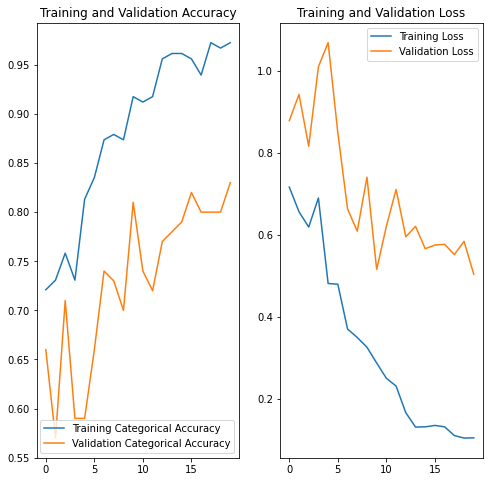

In [21]:
# Visualize the Model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 2 - Convolutional Neural Nework

In [22]:
# Define the model
model_2 = Sequential()
model_2.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(30//img_select,img_width,img_height,channel),padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_2.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_2.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_2.add(Dropout(0.50))
model_2.add(Flatten())
model_2.add(Dense(128,activation='relu'))
model_2.add(Dense(5,activation='softmax'))

## Experiment 3
#### Model = model_2
#### Type = Convolutional Neural Network
#### Optimizer = Adam
#### num_epochs = 20
#### batch_size = 50
#### Generator = generator_crop_resize

In [23]:
train_generator = generator_crop_resize(train_path, train_doc, batch_size)
val_generator = generator_crop_resize(val_path, val_doc, batch_size)

In [24]:
# Model compile
opt = keras.optimizers.Adam(learning_rate=lr)
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [25]:
# Model fit
history = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project1/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - 45s 3s/step - loss: 1.7516 - categorical_accuracy: 0.1890 - val_loss: 1.5713 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2021-03-0722_23_02.408022/model-00001-1.67358-0.18854-1.57134-0.29000.h5
Epoch 2/20
14/14 [==============================] - 19s 1s/step - loss: 1.5934 - categorical_accuracy: 0.2201 - val_loss: 1.4656 - val_categorical_accuracy: 0.3600

Epoch 00002: saving model to model_init_2021-03-0722_23_02.408022/model-00002-1.57932-0.24725-1.46564-0.36000.h5
Epoch 3/20
14/14 [==============================] - 20s 2s/step - loss: 1.4942 - categorical_accuracy: 0.3718 - val_loss: 1.3222 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2021-03-0722_23_02.408022/model-00003-1.45091-0.36264-1.32216-0.43000.h5
Epoch 4/20
14/14 [==============================] - 18s 1s/step - loss: 1.2596 - categorical_acc

In [26]:
# Model summary
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_4 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 3, 30, 30, 64)    

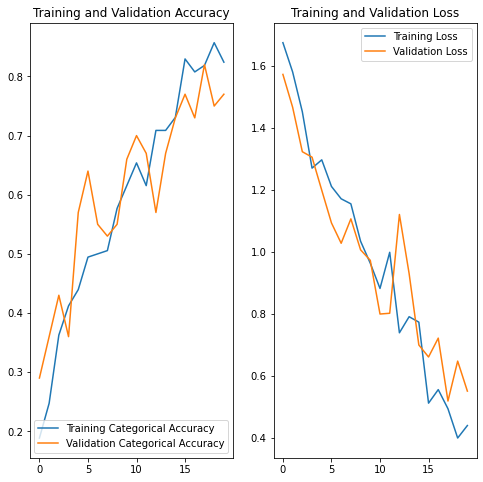

In [27]:
# Visualize the Model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 4
#### Model = model_2
#### Type = Convolutional Neural Network
#### Optimizer = Adam
#### num_epochs = 20
#### batch_size = 50
#### Generator = generator_resize

In [28]:
train_generator = generator_resize(train_path, train_doc, batch_size)
val_generator = generator_resize(val_path, val_doc, batch_size)

In [29]:
# Model compile
opt = keras.optimizers.Adam(learning_rate=lr)
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [30]:
# Model fit
history = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project1/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - 46s 3s/step - loss: 0.6832 - categorical_accuracy: 0.7563 - val_loss: 0.6903 - val_categorical_accuracy: 0.7300

Epoch 00001: saving model to model_init_2021-03-0722_23_02.408022/model-00001-0.62395-0.76320-0.69029-0.73000.h5
Epoch 2/20
14/14 [==============================] - 20s 2s/step - loss: 0.4765 - categorical_accuracy: 0.7868 - val_loss: 0.7106 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2021-03-0722_23_02.408022/model-00002-0.48509-0.79121-0.71056-0.66000.h5
Epoch 3/20
14/14 [==============================] - 20s 2s/step - loss: 0.4736 - categorical_accuracy: 0.8149 - val_loss: 0.6581 - val_categorical_accuracy: 0.7700

Epoch 00003: saving model to model_init_2021-03-0722_23_02.408022/model-00003-0.42843-0.84615-0.65815-0.77000.h5
Epoch 4/20
14/14 [==============================] - 19s 1s/step - loss: 0.5099 - categorical_acc

In [31]:
# Model summary
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_4 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 3, 30, 30, 64)    

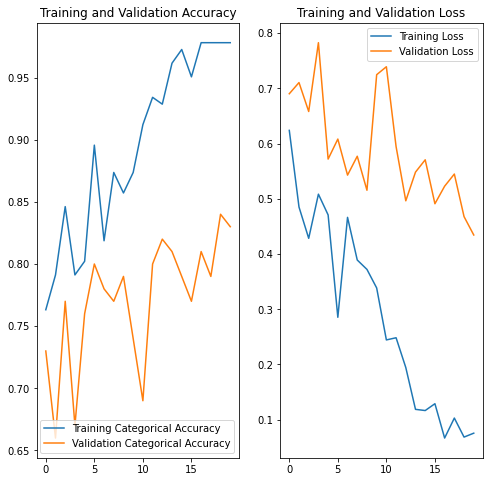

In [32]:
# Visualize the Model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 3 - Convolutional Neural Nework

In [33]:
# Define the model
model_3 = Sequential()
model_3.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(30//img_select,img_width,img_height,channel),padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Dropout(0.25))
model_3.add(Flatten())
model_3.add(Dense(128,activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(64,activation='relu'))
model_3.add(Dense(5,activation='softmax'))

## Experiment 5
#### Model = model_3
#### Type = Convolutional Neural Network
#### Optimizer = Adam
### num_epochs = 20
#### batch_size = 50
#### Generator = generator_crop_resize

In [34]:
train_generator = generator_crop_resize(train_path, train_doc, batch_size)
val_generator = generator_crop_resize(val_path, val_doc, batch_size)

In [35]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=lr)
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [36]:
# Model fit
history = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project1/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - 45s 3s/step - loss: 1.6930 - categorical_accuracy: 0.2230 - val_loss: 1.5623 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-03-0722_23_02.408022/model-00001-1.64867-0.22021-1.56232-0.23000.h5
Epoch 2/20
14/14 [==============================] - 19s 1s/step - loss: 1.5526 - categorical_accuracy: 0.2305 - val_loss: 1.4411 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2021-03-0722_23_02.408022/model-00002-1.54135-0.24725-1.44109-0.40000.h5
Epoch 3/20
14/14 [==============================] - 19s 1s/step - loss: 1.4432 - categorical_accuracy: 0.3547 - val_loss: 1.5735 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_2021-03-0722_23_02.408022/model-00003-1.45521-0.32418-1.57350-0.33000.h5
Epoch 4/20
14/14 [==============================] - 19s 1s/step - loss: 1.5086 - categorical_acc

In [37]:
# Model summary
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_6 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_7 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 3, 30, 30, 64)    

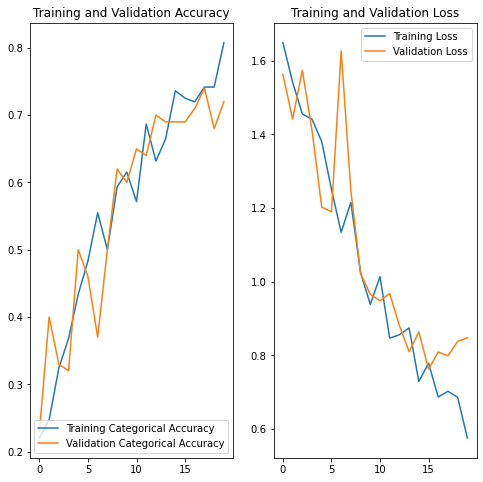

In [38]:
# Visualize the Model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Experiment 6
#### Model = model_3
#### Type = Convolutional Neural Network
#### Optimizer = Adam
### num_epochs = 20
#### batch_size = 50
#### Generator = generator_resize

In [39]:
train_generator = generator_crop_resize(train_path, train_doc, batch_size)
val_generator = generator_crop_resize(val_path, val_doc, batch_size)

In [40]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=lr)
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [41]:
# Fit the model
history = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project1/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - 48s 4s/step - loss: 0.7854 - categorical_accuracy: 0.7247 - val_loss: 0.7955 - val_categorical_accuracy: 0.6700

Epoch 00001: saving model to model_init_2021-03-0722_23_02.408022/model-00001-0.74787-0.72247-0.79554-0.67000.h5
Epoch 2/20
14/14 [==============================] - 19s 1s/step - loss: 0.6507 - categorical_accuracy: 0.7394 - val_loss: 0.9187 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2021-03-0722_23_02.408022/model-00002-0.63597-0.75824-0.91873-0.64000.h5
Epoch 3/20
14/14 [==============================] - 19s 1s/step - loss: 0.6206 - categorical_accuracy: 0.7506 - val_loss: 1.1301 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2021-03-0722_23_02.408022/model-00003-0.71469-0.71978-1.13013-0.57000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
14/1

In [42]:
# Model summary
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
activation_6 (Activation)    (None, 15, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
activation_7 (Activation)    (None, 7, 60, 60, 32)     0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 3, 30, 30, 64)    

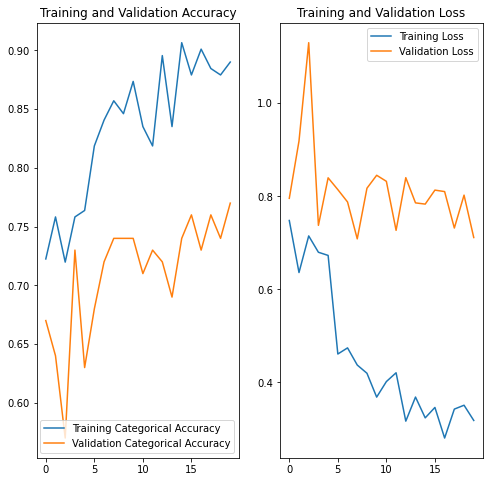

In [43]:
# Visualize the Model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 4
# Timedistributed - Conv2D + RNN model

In [44]:
# Define the model
model_4 = Sequential()
model_4.add(TimeDistributed(Conv2D(16, kernel_size=(3,3), padding='same',strides=(2,2),activation='relu'),input_shape=(30//img_select,img_width,img_height,channel)))
model_4.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),strides=(2,2))))
model_4.add(TimeDistributed(Conv2D(32, kernel_size=(3,3), padding='same',strides=(2,2),activation='relu')))
model_4.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),strides=(2,2))))
model_4.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), padding='same',strides=(2,2),activation='relu')))
model_4.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),strides=(2,2))))
model_4.add(Dropout(0.25))
model_4.add(TimeDistributed(Flatten()))
model_4.add(LSTM(128, activation='relu'))
model_4.add(Dense(128,activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(64,activation='relu'))
model_4.add(Dense(5,activation='softmax'))

## Experiment 7
#### Model = model_4
#### Type = Timedistributed - Conv2D + RNN (LSTM)
#### Optimizer = Adam
#### num_epochs = 20
#### batch_size = 50
#### Generator = generator_crop_resize

In [45]:
# Defining variable
num_epochs = 20
batch_size = 50

In [46]:
train_generator = generator_crop_resize(train_path, train_doc, batch_size)
val_generator = generator_crop_resize(val_path, val_doc, batch_size)

In [47]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=lr)
model_4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [48]:
# Fit the model
history = model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project1/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - 46s 3s/step - loss: 1.6095 - categorical_accuracy: 0.1919 - val_loss: 1.5933 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-03-0722_23_02.408022/model-00001-1.60734-0.20060-1.59327-0.23000.h5
Epoch 2/20
14/14 [==============================] - 20s 2s/step - loss: 1.5763 - categorical_accuracy: 0.2622 - val_loss: 1.5464 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2021-03-0722_23_02.408022/model-00002-1.56936-0.28022-1.54641-0.26000.h5
Epoch 3/20
14/14 [==============================] - 19s 1s/step - loss: 1.6235 - categorical_accuracy: 0.1684 - val_loss: 1.6017 - val_categorical_accuracy: 0.2900

Epoch 00003: saving model to model_init_2021-03-0722_23_02.408022/model-00003-1.61431-0.19780-1.60172-0.29000.h5
Epoch 4/20
14/14 [==============================] - 20s 2s/step - loss: 1.6071 - categorical_acc

In [49]:
# Model summary
print(model_4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 15, 15, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 7, 7, 32)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 4, 4, 64)      18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 2, 2, 64)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 2, 2, 64)     

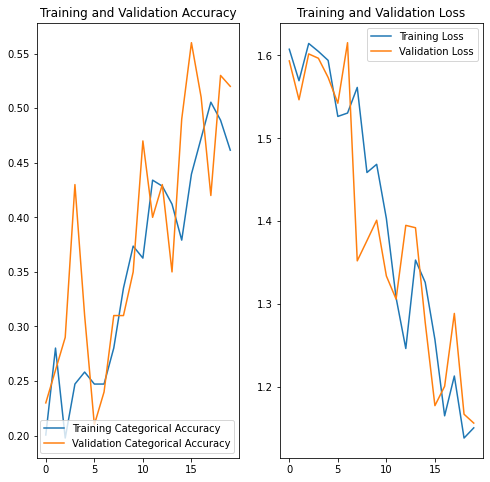

In [50]:
# Visualize the Model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 5
# Timedistributed - Conv2D + RNN model

In [51]:
# Define the model
model_5 = Sequential()
model_5.add(TimeDistributed(Conv2D(16, kernel_size=(3,3), padding='same',strides=(2,2),activation='relu'),input_shape=(30//img_select,img_width,img_height,channel)))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),strides=(2,2))))
model_5.add(TimeDistributed(Conv2D(32, kernel_size=(3,3), padding='same',strides=(2,2),activation='relu')))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),strides=(2,2))))
model_5.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), padding='same',strides=(2,2),activation='relu')))
model_5.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),strides=(2,2))))
model_5.add(Dropout(0.25))
model_5.add(TimeDistributed(Flatten()))
model_5.add(GRU(128,activation='relu'))
model_5.add(Dense(128,activation='relu'))
model_5.add(Dropout(0.25))
model_5.add(Dense(64,activation='relu'))
model_5.add(Dense(5,activation='softmax'))

## Experiment 8
#### Model = model_5
#### Type = Timedistributed - Conv2D + RNN (GRU)
#### Optimizer = Adam
#### num_epochs = 20
#### batch_size = 50
#### Generator = generator_crop_resize

In [52]:
# Defining variable
num_epochs = 30
batch_size = 50

In [53]:
train_generator = generator_crop_resize(train_path, train_doc, batch_size)
val_generator = generator_crop_resize(val_path, val_doc, batch_size)

In [54]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=lr)
model_5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [55]:
# Fit the model
history = model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project1/Project_data/train ; batch size = 50
Epoch 1/30
14/14 [==============================] - 45s 3s/step - loss: 1.6079 - categorical_accuracy: 0.2058 - val_loss: 1.5956 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2021-03-0722_23_02.408022/model-00001-1.60743-0.19005-1.59563-0.20000.h5
Epoch 2/30
14/14 [==============================] - 20s 2s/step - loss: 1.5990 - categorical_accuracy: 0.1548 - val_loss: 1.5876 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2021-03-0722_23_02.408022/model-00002-1.60367-0.17582-1.58760-0.18000.h5
Epoch 3/30
14/14 [==============================] - 19s 1s/step - loss: 1.5945 - categorical_accuracy: 0.2186 - val_loss: 1.5854 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2021-03-0722_23_02.408022/model-00003-1.58451-0.19780-1.58544-0.24000.h5
Epoch 4/30
14/14 [==============================] - 19s 1s/step - loss: 1.6150 - categorical_acc

In [56]:
# Model summary
print(model_5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 15, 15, 15, 32)    4640      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 7, 7, 32)      0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 4, 4, 64)      18496     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 2, 2, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 2, 2, 64)     

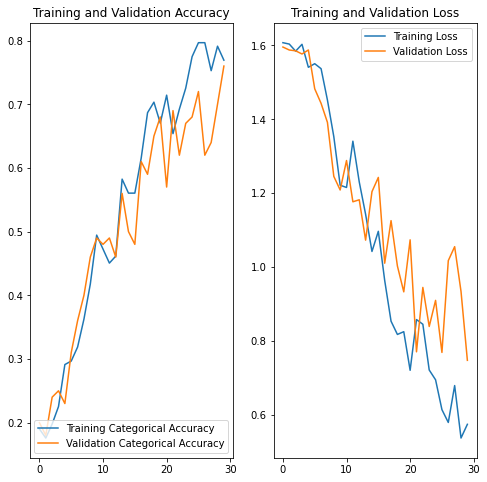

In [57]:
# Visualize the Model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 6
# Mobilenet + GRU

In [58]:
# Defining the model
model_6 = Sequential()
model_6.add(TimeDistributed(MobileNet(input_shape=(img_width,img_height,channel),include_top=False,weights="imagenet"),input_shape=(30//img_select,img_width,img_height,channel)))
model_6.add(TimeDistributed(Flatten()))
model_6.add(GRU(128,activation='relu'))
model_6.add(Dropout(0.25))
model_6.add(Dense(128,activation='relu'))
model_6.add(Dropout(0.25))
model_6.add(Dense(64,activation='relu'))
model_6.add(Dense(5,activation='softmax'))

17227776/17225924 [==============================] - 1s 0us/step


## Experiment 9
#### Model = model_6
#### Type = Mobilenet + GRU
#### Optimizer = Adam
#### num_epochs = 20
#### batch_size = 50
#### Generator = generator_crop_resize

In [59]:
# Defining variable
num_epochs = 20
batch_size = 50

In [60]:
train_generator = generator_crop_resize(train_path, train_doc, batch_size)
val_generator = generator_crop_resize(val_path, val_doc, batch_size)

In [61]:
# Compiling the model
opt = keras.optimizers.Adam(learning_rate=lr)
model_6.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [62]:
# Model fit
history = model_6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project1/Project_data/train ; batch size = 50
Epoch 1/20
14/14 [==============================] - 52s 4s/step - loss: 2.1186 - categorical_accuracy: 0.2328 - val_loss: 1.4986 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2021-03-0722_23_02.408022/model-00001-1.85712-0.29864-1.49858-0.38000.h5
Epoch 2/20
14/14 [==============================] - 21s 2s/step - loss: 1.1723 - categorical_accuracy: 0.5839 - val_loss: 1.4058 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2021-03-0722_23_02.408022/model-00002-1.12346-0.58242-1.40576-0.46000.h5
Epoch 3/20
14/14 [==============================] - 21s 2s/step - loss: 1.3506 - categorical_accuracy: 0.5194 - val_loss: 0.8209 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2021-03-0722_23_02.408022/model-00003-1.20894-0.54945-0.82091-0.66000.h5
Epoch 4/20
14/14 [==============================] - 20s 1s/step - loss: 1.1287 - categorical_acc

In [63]:
# Model summary
print(model_6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 9216)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               3588864   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)               

## The final model choosen is as follows:
### model-00019-0.42694-0.89011-0.30344-0.88000.h5
### Experiment Number 9
### Epoch Number 19 
### Categorical Accuracy = 89.01% 
### VAL Categorical Accuracy = 88%